In [7]:
cd sales

C:\Users\ASUS\sales


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

In [16]:
df=pd.read_csv('train.csv')
tf = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission_LMg97w5.csv')

submission['User_ID'] = tf['User_ID']
submission['Product_ID'] = tf['Product_ID']

In [13]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [14]:
#Since User_ID and Product_ID will not give us much information we will drop them from our dataset.

In [25]:
df.drop(['User_ID'],inplace=True,axis=1)
tf.drop(['User_ID'],inplace=True,axis=1)

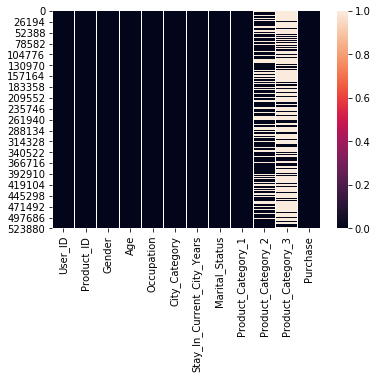

In [17]:
#To check nan values are available or  not:
sns.heatmap(df.isnull())

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 11 columns):
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 46.2+ MB


In [18]:
#Age is given in the form of range:
print(df.Age.value_counts())
df.Age.replace({'0-17':'0','18-25':'1','26-35':'2','36-45':'3','46-50':'4','51-55':'5','55+':'6'},inplace=True)
# Converting to int
df.Age = df.Age.astype('int64')
#For test data:
print(tf.Age.value_counts())
tf.Age.replace({'0-17':'0','18-25':'1','26-35':'2','36-45':'3','46-50':'4','51-55':'5','55+':'6'},inplace=True)
# Converting to int
tf.Age = tf.Age.astype('int64')

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64
26-35    93428
36-45    46711
18-25    42293
46-50    19577
51-55    16283
55+       9075
0-17      6232
Name: Age, dtype: int64


In [19]:
print(df.Gender.value_counts())
df.Gender.replace({'F':0,'M':1},inplace=True)
#For test data:
tf.Gender.replace({'F':0,'M':1},inplace=True)

M    414259
F    135809
Name: Gender, dtype: int64


In [20]:
#We can see clearly there are 3 types of City_Category:
df.City_Category.value_counts()
df.City_Category.replace({'A':'0','B':'1','C':'2'},inplace=True)
# Converting to int
df.City_Category = df.City_Category.astype('int64')
#For test data:
tf.City_Category.value_counts()
tf.City_Category.replace({'A':'0','B':'1','C':'2'},inplace=True)
# Converting to int
tf.City_Category = tf.City_Category.astype('int64')

In [21]:
# In Stay_In_Current_City the 4+ value can converted into int.
df.Stay_In_Current_City_Years.value_counts()
df.Stay_In_Current_City_Years.replace({'4+':4},inplace=True)
df.Stay_In_Current_City_Years = df.Stay_In_Current_City_Years.astype('int64')
#For test data:
tf.Stay_In_Current_City_Years.value_counts()
tf.Stay_In_Current_City_Years.replace({'4+':4},inplace=True)
tf.Stay_In_Current_City_Years = tf.Stay_In_Current_City_Years.astype('int64')

In [115]:
#Proportion of null values in Product_Category_2:
print("NUll values:",df.Product_Category_2.isna().sum())
print("Percentage of Null values: "+str(round((df.Product_Category_2.isna().sum()/len(df))*100,1)))

NUll values: 173638
Percentage of Null values: 31.6


In [116]:
#Proportion of null values in Product_Category_3:
print("NUll values:",df.Product_Category_3.isna().sum())
print("Percentage of Null values: "+str(round((df.Product_Category_3.isna().sum()/len(df))*100,1)))


NUll values: 383247
Percentage of Null values: 69.7


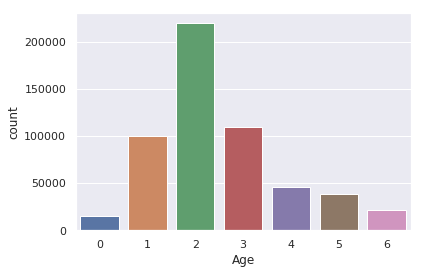

In [117]:
sns.countplot("Age",data=df)

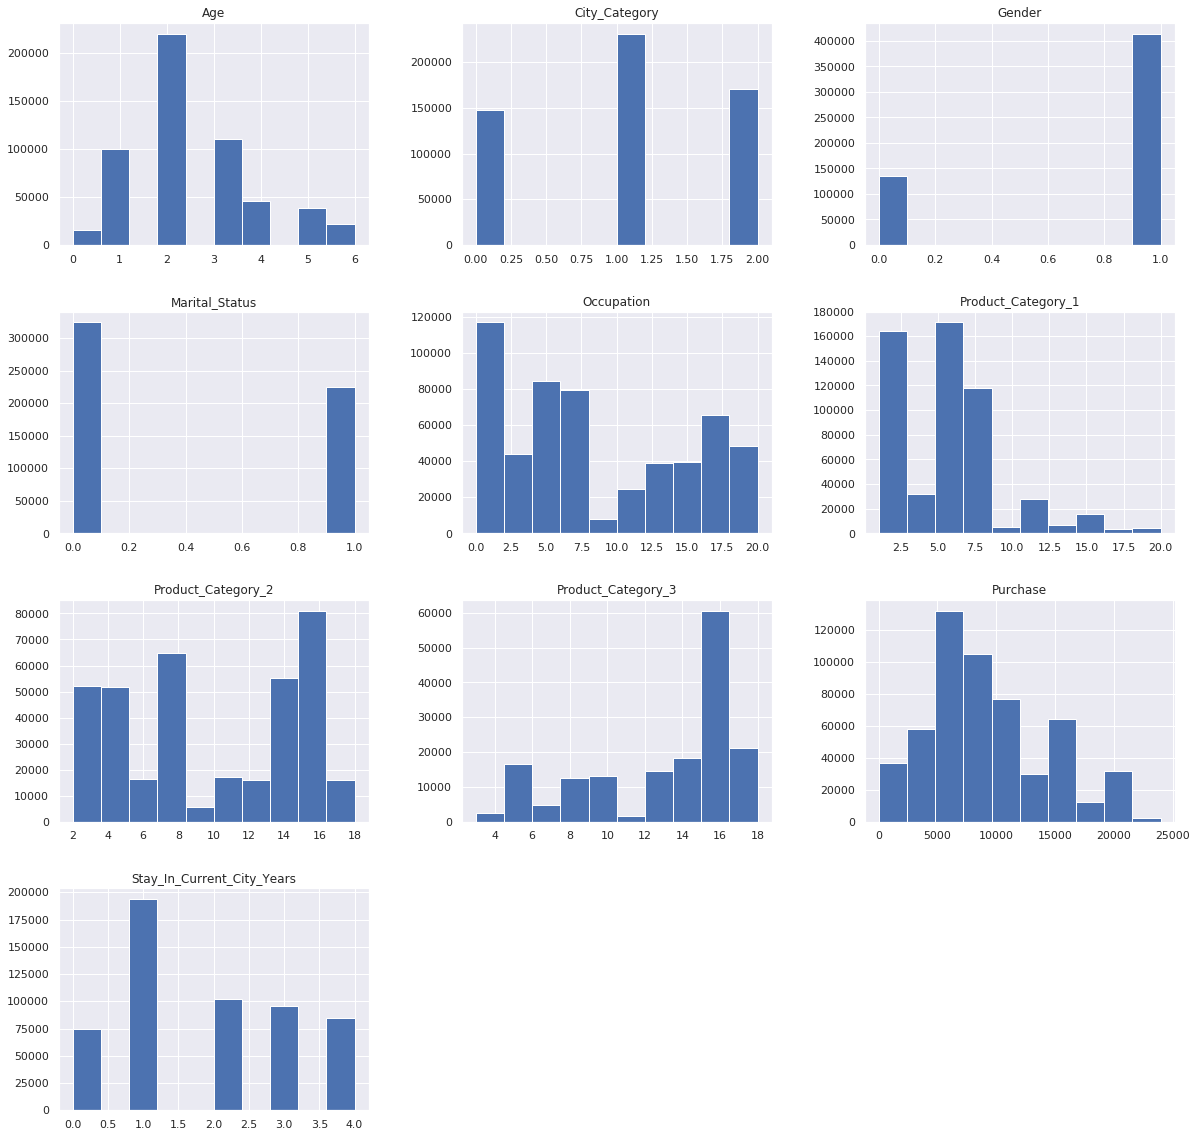

In [118]:
# Plotting the distribution of numerical  categories
df.hist(figsize=(20,20));

In [22]:
#We can clearly see ou purchase data is right skew so now we will use function:
df['log_Purchase'] = np.log(df['Purchase'])


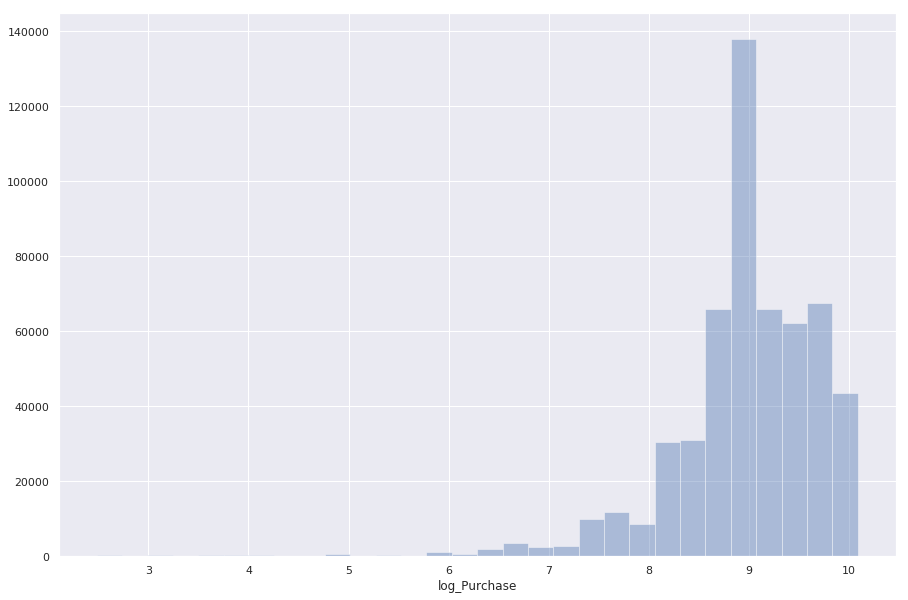

In [120]:
plt.figure(figsize=(15,10))
sns.distplot(df['log_Purchase'],bins=30,kde=False)

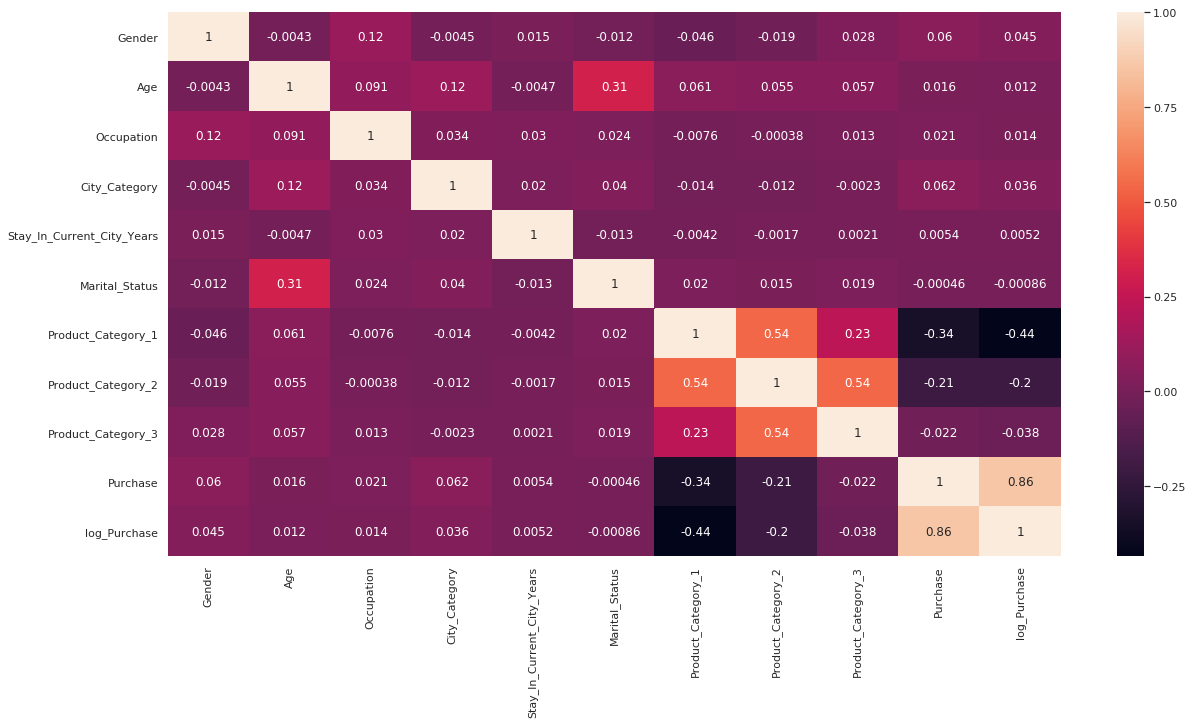

In [121]:
# Create a covariance matrix and plotting a heatmap to show linearity or non linearity between different columns:

plt.figure(figsize=(20,10))
corr = df.corr()
sns.set(font_scale=1)
heat_map = sns.heatmap(corr, annot=True)
plt.show()

In [23]:
#Now we will handle the missing values, we will fill nan values with mean:
#Now we will handle the missing values, we will fill nan values with mean:
df.Product_Category_2.fillna(df.Product_Category_2.mean(),inplace=True)
df.Product_Category_3.fillna(df.Product_Category_3.mean(),inplace=True)
df.info()
tf.Product_Category_2.fillna(tf.Product_Category_2.mean(),inplace=True)
tf.Product_Category_3.fillna(df.Product_Category_3.mean(),inplace=True)
tf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 13 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null int64
Age                           550068 non-null int64
Occupation                    550068 non-null int64
City_Category                 550068 non-null int64
Stay_In_Current_City_Years    550068 non-null int64
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            550068 non-null float64
Product_Category_3            550068 non-null float64
Purchase                      550068 non-null int64
log_Purchase                  550068 non-null float64
dtypes: float64(3), int64(9), object(1)
memory usage: 54.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 11 columns):
User_ID                       23

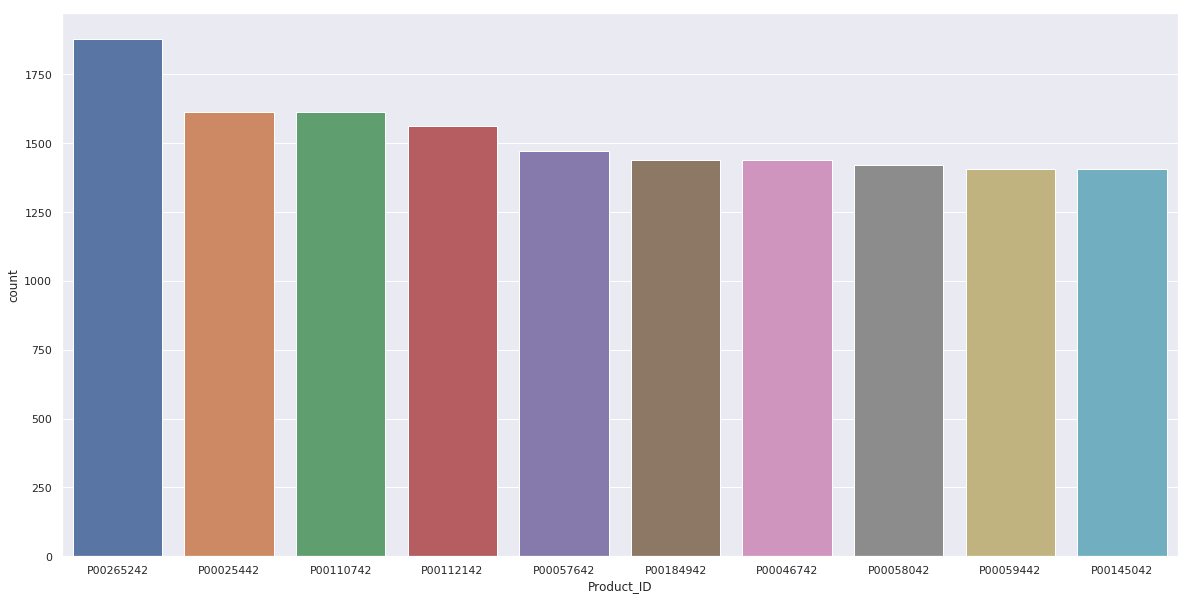

In [127]:
#Plotting the top products sold:
plt.figure(figsize=(20,10))
sns.countplot(x = 'Product_ID',
              data = df,
              order = df['Product_ID'].value_counts(sort=True)[:10].index)

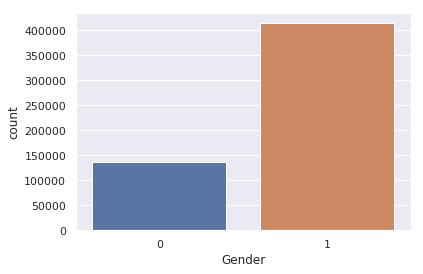

In [131]:
sns.countplot(x='Gender',data=df)
#0 is for female and 1 is for male. We can clearly see that male spend more then females.

In [24]:
df.drop(['Product_ID'],inplace=True,axis=1)
tf.drop(['Product_ID'],inplace=True,axis=1)

In [30]:
#Now  we will create our model:
X=df.iloc[:,:-2]
Y=df['log_Purchase']
X_test = tf


In [33]:
from sklearn.model_selection import train_test_split
# Splitting into train and test sets
X_train, X_value, y_train, y_value = train_test_split(X, Y, test_size=0.2, random_state=1)

In [34]:


reg = xgb.XGBRegressor(learning_rate=0.5, max_depth=6, min_child_weight=40, seed=0)
reg.fit(X_train, y_train)
training_pred = reg.predict(X_train)
val_preds = reg.predict(X_value)
print("\nTraining MSE:", round(mean_squared_error(y_train, training_pred),4))
print("Validation MSE:", round(mean_squared_error(y_value, val_preds),4))
print("\nTraining r2:", round(r2_score(y_train, training_pred),4))
print("Validation r2:", round(r2_score(y_value, val_preds),4))

C:\Users\ASUS\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training MSE: 0.1295
Validation MSE: 0.133

Training r2: 0.7629
Validation r2: 0.7602


In [37]:
rmse = np.sqrt(mean_squared_error(val_preds, y_value))
rmse

0.3646415469411697

In [40]:
reg.fit(X, Y)
Y_pred = reg.predict(X_test)
submission['Purchase'] = np.exp(Y_pred)
submission.to_csv('sample_submission_LMg97w5.csv', index=False)

[12:26:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
